In [2]:
import sys
sys.path.append('../')
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from models.resnet import ResNet18
import fnmatch

# external
from experiments.activation.acts import *
# from experiments.activation.GLUs import *
from experiments.util.utils import *


In [3]:
def load_model_checkpoints(folder_path, activation_fns, repeats):
    """Load model checkpoints and gather validation accuracies into a structured dictionary.

    Args:
        folder_path (str): Path to the folder where the checkpoints are saved.
        activation_fns (list): List of activation function names as strings.
        repeats (int): Number of repeats for each activation function.

    Returns:
        dict: A dictionary with activation function names as keys and lists of dictionaries (each containing 'top1' and 'top5' accuracies) as values.
    """
    all_accuracies = {act_fn: [] for act_fn in activation_fns}

    for act_fn in activation_fns:
        # if act_fn == 'GLU': continue
        if act_fn in 'SwishT_C_learnable_alpha': continue
        print(act_fn)
        for i in range(1, repeats + 1):
            if act_fn == 'SwishT':
                file_name_pattern = f"{i}_ckpt_*_{act_fn}_[0-9]*.pth"
            elif 'SwishT_[A-Z]' in act_fn and act_fn != 'SwishT_C_learnable_alpha':
                file_name_pattern = f"{i}_ckpt_*_{act_fn}_[0-9]*.pth"
            else:
                file_name_pattern = f"{i}_ckpt_*_{act_fn}_*.pth"
            for file_name in os.listdir(folder_path):
                if fnmatch.fnmatch(file_name, file_name_pattern):
                    # if 'SMU' == act_fn and file_name.split('_'):
                    if 'SMU' == act_fn and len(file_name.split('_')) == 7:
                        continue
                    checkpoint_path = os.path.join(folder_path, file_name)
                    try:
                        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))  # Ensure the checkpoint is loaded in CPU mode
                    except:
                        import sys
                        sys.path.append('/workspace/pytorch_resnet_cifar10/')
                        from pytorch_resnet_cifar10.acts_without_abc import SwishT,SwishT_A,SwishT_B,SwishT_C,Swish,Mish,GELU,SiLU,SMU,Pserf,ErfAct   
                        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
                    accuracy_data = {
                        'top1': checkpoint['top1'],
                        'top5': checkpoint['top5'],
                    }
                    all_accuracies[act_fn].append(accuracy_data)
                    if 'act.beta' in checkpoint['net'].keys():
                        accuracy_data['beta'] = checkpoint['net']['act.beta'].cpu().numpy()
                    elif 'module.act.beta' in checkpoint['net'].keys():
                        accuracy_data['beta'] = checkpoint['net']['module.act.beta'].cpu().numpy()
                    else:
                        accuracy_data['beta'] = np.nan
                
    return all_accuracies

def summarize_accuracies(accuracies_dict):
    """Summarize accuracies into a DataFrame with statistical measures.

    Args:
        accuracies_dict (dict): A dictionary with activation function names as keys and lists of accuracies as values.
                                Each value list contains dictionaries with keys 'top1' and 'top5'.

    Returns:
        DataFrame: A DataFrame with activation function names as indices and statistical measures as columns.
    """
    # Prepare data for DataFrame
    data = []
    index = []
    for act_fn, results in accuracies_dict.items():
        top1_scores = [result['top1'] for result in results]
        top5_scores = [result['top5'] for result in results]
        betas = [result['beta'] for result in results]

        summary = {
            'Mean of top1': np.mean(top1_scores),
            'Std of top1': np.std(top1_scores),
            'Mean of top5': np.mean(top5_scores),
            'Std of top5': np.std(top5_scores),
            'Mean of beta': np.mean(betas),
            'Std of beta': np.std(betas),
            'Betas': [np.round(beta, 2) for beta in betas]
        }
        data.append(summary)
        index.append(act_fn)

    # Create DataFrame
    df = pd.DataFrame(data, index=index)
    df = df.round(2)

    return df

def plot_accuracies_boxplot(accuracies_dict, accuracy_type='top1', figsize=(10, 8)):
    """Plot a boxplot of the accuracies for each activation function based on specified accuracy type ('top1' or 'top5') and figure size.

    Args:
        accuracies_dict (dict): A dictionary with activation function names as keys and lists of dictionaries (each containing 'top1' and 'top5' accuracies) as values.
        accuracy_type (str): The type of accuracy to plot ('top1' or 'top5').
        figsize (tuple): Tuple specifying the figure size.
    """
    labels = list(accuracies_dict.keys())
    accuracies = [[result[accuracy_type] for result in accuracies_dict[act_fn]] for act_fn in labels]

    fig, ax = plt.subplots(figsize=figsize)
    ax.boxplot(accuracies, labels=labels)
    ax.set_title(f'Comparison of Activation Functions ({accuracy_type} Accuracy)')
    ax.set_xlabel('Activation Function')
    ax.set_ylabel(f'Validation Accuracy ({accuracy_type})')

    plt.show()

def reindex_dataframe_with_trainability(df:pd.DataFrame, non_trainable_funcs, ours,drop_act):
    """Modify DataFrame index to include trainability status and move specified functions to the bottom of each group.

    Args:
        df (pd.DataFrame): The DataFrame to modify.
        non_trainable_funcs (list): List of function names considered non-trainable.
        ours (list): List of function names that should be labeled as "(ours)" and moved to the bottom.

    Returns:
        pd.DataFrame: The DataFrame with the updated MultiIndex and modified function names.
    """
    df = df.copy()
    df['Trainable'] = df.index.to_series().apply(lambda x: 'No' if x in non_trainable_funcs else 'Yes')
    df['Sort Key'] = df.index.to_series().apply(lambda x: x + ' (ours)' if x in ours else x)
    df['Sort Priority'] = df.index.to_series().apply(lambda x: 1 if x in ours else 0)
    df_sorted = df.sort_values(by=['Trainable', 'Sort Priority', 'Sort Key'])
    df_sorted.index = pd.MultiIndex.from_arrays([df_sorted['Trainable'], df_sorted['Sort Key']], names=['Trainable', 'Activation Function'])
    df_sorted = df_sorted.drop(columns=['Trainable', 'Sort Key', 'Sort Priority'])

    if drop_act:
        df_sorted.drop(drop_act, level='Activation Function',inplace=True)

    return df_sorted


### Resnet18 1.1M

In [6]:
# base activations 
from experiments.activation.acts import *
from pprint import pprint

############# 1.1 M Resnet18 CIFAR10/100 result ##############
folder_path = './checkpoint/dev_cifar100' 
repeats = 5  # Total number of repeats
# activation_fns = get_activations(return_type='list')
# activation_fns = [act.__class__.__name__ for act in activation_fns]
# activation_fns = ['SwishT','SliuT','ASN','Swish','Mish','GELU','SiLU']
# activation_fns += ['SwishT_A','SwishT_B','SwishT_C','SliuT',]

activation_fns = ['SwishT_A','SwishT_B','SwishT_C']
activation_fns += ['SwishT','Swish','SMU','SMU_1','ReLU','Mish','GELU','SiLU','SwishT_C6','SwishT_B6','Swish_6','SMU1']

accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)

# Plot the boxplot for comparison
# plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
# plot_accuracies_boxplot(accuracies_dict,accuracy_type='top5')
df = summarize_accuracies(accuracies_dict)
# display(df)
display(df.sort_values(by='Mean of top1',ascending=False))

############## CIFAR10
folder_path = './checkpoint/dev_cifar10' 
# activation_fns = ['SwishT','SliuT','ASN','Swish','Mish','GELU','SiLU']
accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)
# plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
df = summarize_accuracies(accuracies_dict)
# df.sort_values(by='Mean of top1',ascending=False)
df

SwishT_A
SwishT_B
SMU
SMU_1
ReLU
Mish
GELU
SiLU
SwishT_C6
SwishT_B6
Swish_6
SMU1


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
SMU_1,78.85,0.19,94.11,0.18,NaN,NaN,"[nan, nan, nan, nan, nan]"
Swish_6,78.84,0.28,94.25,0.21,6.00,0.00,"[[6.0], [6.0], [6.0], [6.0], [6.0]]"
SwishT_B6,78.81,0.27,94.10,0.06,6.00,0.00,"[[6.0], [6.0], [6.0], [6.0], [6.0]]"
ReLU,78.46,0.15,94.18,0.16,NaN,NaN,"[nan, nan, nan, nan, nan]"
SMU,78.44,0.26,94.16,0.18,NaN,NaN,"[nan, nan, nan, nan, nan]"
SMU1,78.27,0.19,94.01,0.20,NaN,NaN,"[nan, nan, nan, nan, nan]"
GELU,78.08,0.26,93.92,0.17,NaN,NaN,"[nan, nan, nan, nan, nan]"
SwishT_B,77.24,0.99,93.18,0.51,1.49,0.02,"[[1.49], [1.5], [1.48], [1.53], [1.46]]"
Mish,77.16,0.24,93.53,0.14,NaN,NaN,"[nan, nan, nan, nan, nan]"
SwishT_C6,76.97,2.43,92.94,1.63,6.00,0.00,"[[6.0], [6.0], [6.0], [6.0], [6.0], [6.0], [6...."


SwishT_A
SwishT_B
SMU
SMU_1
ReLU
Mish
GELU
SiLU
SwishT_C6
SwishT_B6
Swish_6
SMU1


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
SwishT_A,94.17,0.12,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
SwishT_B,95.17,0.21,0.0,0.0,1.49,0.09,"[[1.51], [1.4], [1.38], [1.52], [1.62]]"
SwishT_C,NaN,NaN,NaN,NaN,NaN,NaN,[]
SwishT,NaN,NaN,NaN,NaN,NaN,NaN,[]
Swish,NaN,NaN,NaN,NaN,NaN,NaN,[]
SMU,95.12,0.16,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
SMU_1,95.58,0.03,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
ReLU,95.54,0.08,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
Mish,94.36,0.12,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
GELU,94.79,0.16,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"


### Resnet 20 32 44 56 110

{'SwishT_B': [{'top1': 68.47, 'top5': 90.89, 'beta': array([-1.1248015], dtype=float32)}], 'SwishT_C': [{'top1': 68.29, 'top5': 90.89, 'beta': array([1.30019], dtype=float32)}], 'Swish': [{'top1': 68.35, 'top5': 90.63, 'beta': array([-1.1972264], dtype=float32)}], 'SiLU': [{'top1': 68.03, 'top5': 90.87, 'beta': nan}]}
{'SwishT_B': [{'top1': 70.27, 'top5': 91.27, 'beta': array([-1.3726318], dtype=float32)}], 'SwishT_C': [{'top1': 69.87, 'top5': 91.55, 'beta': array([1.6141629], dtype=float32)}], 'Swish': [{'top1': 69.86, 'top5': 91.34, 'beta': array([1.4725318], dtype=float32)}], 'SiLU': [{'top1': 69.73, 'top5': 91.21, 'beta': nan}]}
{'SwishT_B': [{'top1': 70.73, 'top5': 91.91, 'beta': array([-1.5616575], dtype=float32)}], 'SwishT_C': [{'top1': 71.08, 'top5': 91.81, 'beta': array([-1.8892821], dtype=float32)}], 'Swish': [{'top1': 70.65, 'top5': 91.76, 'beta': array([1.7065828], dtype=float32)}], 'SiLU': [{'top1': 70.26, 'top5': 91.06, 'beta': nan}]}
{'SwishT_B': [{'top1': 70.58, 'top5':

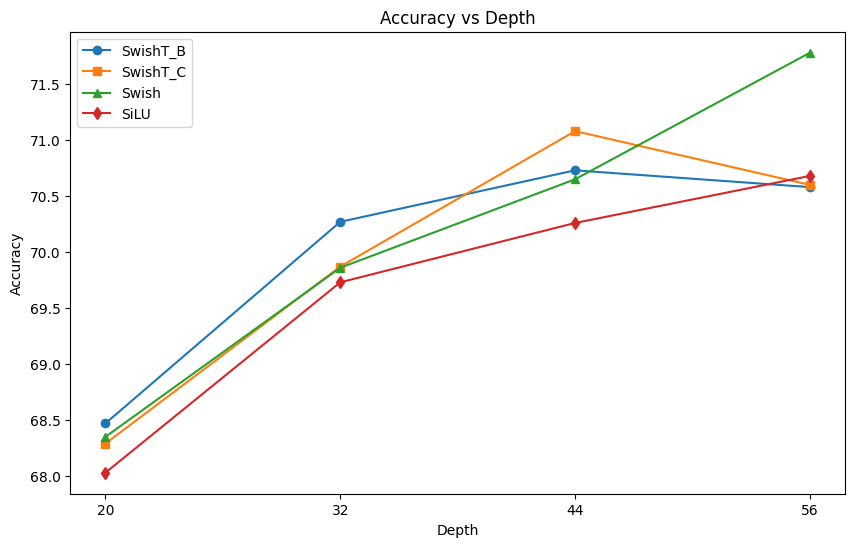

In [21]:
def make_dict_acc_depth(act_name_list,repeats,top5=True):
    root = '/workspace/checkpoint/repeat_train/resnet_depth/'
    depth_list = [20,32,44,56]
    acc_dict = {
        act_name:{'top1':[],'top5':[]}
    for act_name in act_name_list}

    for d in depth_list:
        #  ../pytorch_resnet_cifar10/checkpoint/
        folder_path = f'{root}dev_cifar100/save_resnet{d}/'
        accuracies_dict = load_model_checkpoints(folder_path, act_name_list, repeats)
        print(accuracies_dict)
        for act_name in act_name_list:
            mean_top1_acc = np.mean([result['top1'] for result in accuracies_dict[act_name]])
            acc_dict[act_name]['top1'].append(round(mean_top1_acc,2))
            if top5:
                mean_top5_acc = np.mean([result['top5'] for result in accuracies_dict[act_name]])
                acc_dict[act_name]['top5'].append(round(mean_top5_acc,2))
    return acc_dict

activation_fns = ['SwishT_B','SwishT_C','Swish','SiLU']

def make_fig_acc_depth(results_dict, top1=True, top5=False):
    depth_list = [20, 32, 44, 56]
    markers = ['o', 's', '^', 'd', 'v', 'p', '*', 'h', 'X']  # List of marker styles

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (act_name, results) in enumerate(results_dict.items()):
        if top1:
            accuracies = results['top1']
            ax.plot(depth_list, accuracies, marker=markers[i % len(markers)], label=act_name)
        elif top5:
            accuracies = results['top5']
            ax.plot(depth_list, accuracies, marker=markers[i % len(markers)], label=act_name)

    ax.set_xticks(depth_list)  # Set x-ticks to depth_list values
    ax.set_xlabel('Depth')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy vs Depth')
    ax.legend()
    plt.show()

make_fig_acc_depth(make_dict_acc_depth(activation_fns,1),top1=True,top5=True)

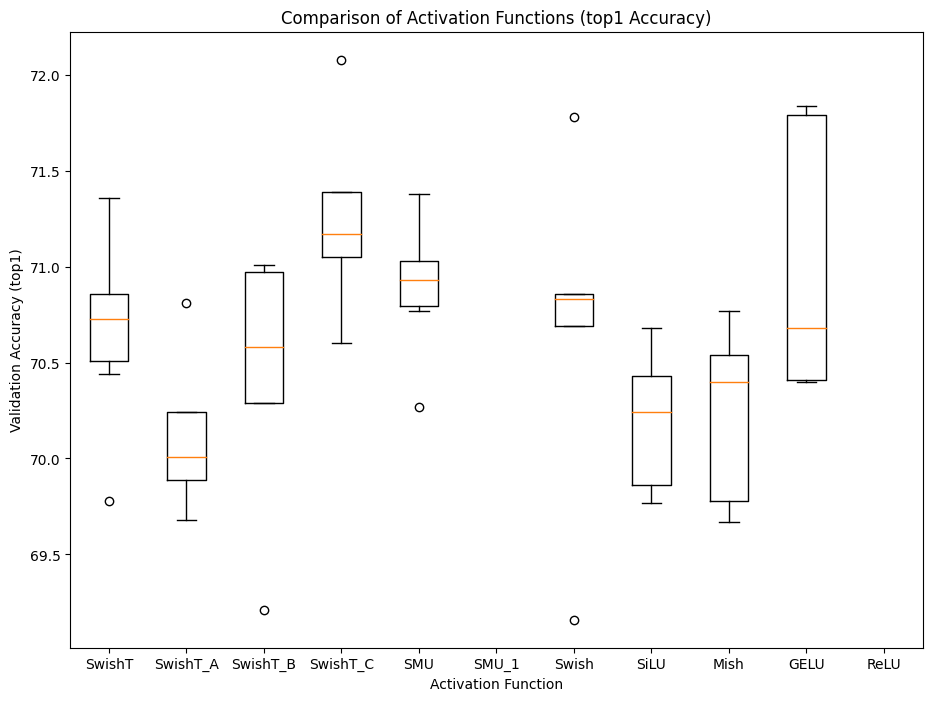

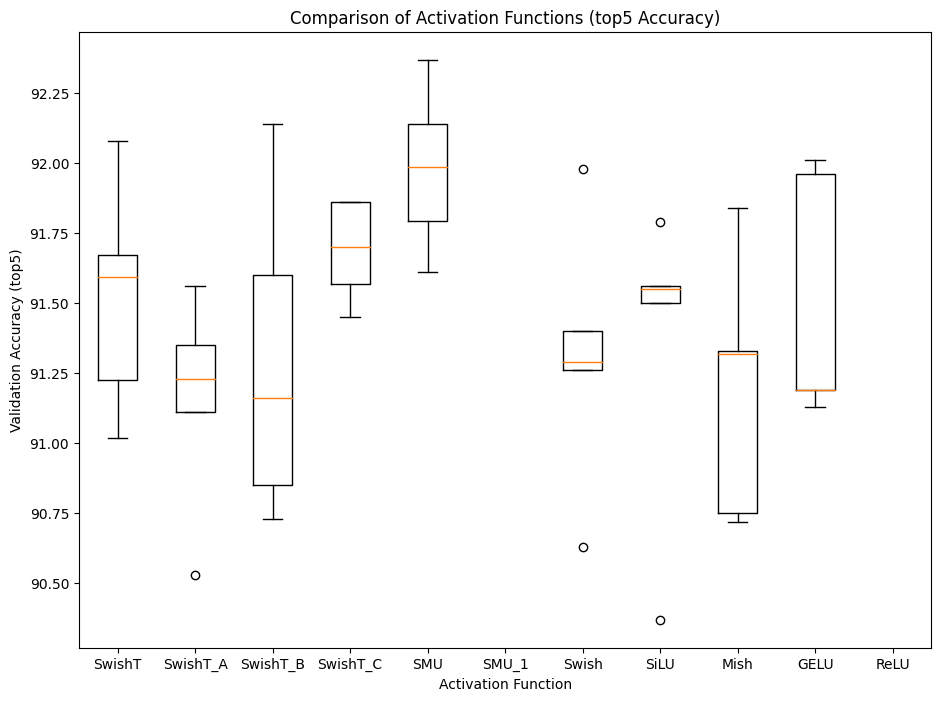

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
SwishT_C,71.258000,0.485197,91.688000,0.161171,2.208758,0.102835,"[[2.08], [2.36], [2.12], [2.21], [2.28]]"
GELU,71.024000,0.653807,91.496000,0.400180,NaN,NaN,"[nan, nan, nan, nan, nan]"
SMU,70.886667,0.335245,91.978333,0.253799,NaN,NaN,"[nan, nan, nan, nan, nan, nan]"
Swish,70.664000,0.845473,91.312000,0.429483,1.980285,0.109107,"[[1.96], [1.97], [1.87], [2.19], [1.92]]"
SwishT,70.655000,0.479366,91.515000,0.357386,-1.904548,0.052884,"[[-1.89], [-1.85], [-1.93], [-1.88], [-2.01], ..."
SwishT_B,70.412000,0.656792,91.296000,0.518174,0.592420,1.947729,"[[2.17], [2.34], [2.03], [-1.77], [-1.81]]"
Mish,70.232000,0.431898,91.192000,0.417967,NaN,NaN,"[nan, nan, nan, nan, nan]"
SiLU,70.196000,0.342146,91.354000,0.502100,NaN,NaN,"[nan, nan, nan, nan, nan]"
SwishT_A,70.126000,0.387019,91.156000,0.346503,NaN,NaN,"[nan, nan, nan, nan, nan]"
SMU_1,NaN,NaN,NaN,NaN,NaN,NaN,[]


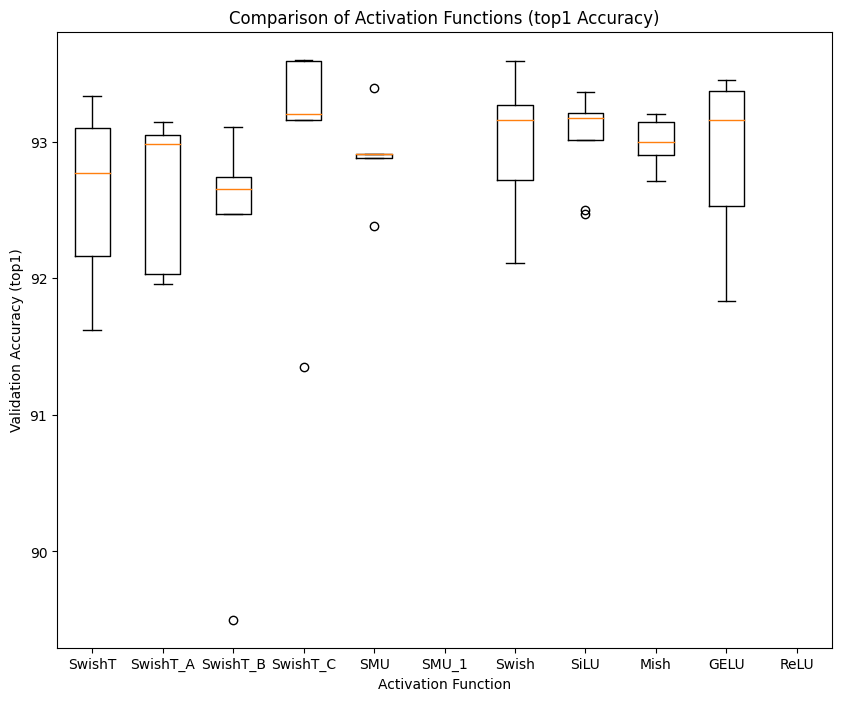

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
Swish,93.028889,0.435366,0.0,0.0,3.432655,0.106405,"[[3.56], [3.49], [3.6], [3.35], [3.24], [3.4],..."
SiLU,93.028889,0.307804,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan]"
Mish,92.980000,0.163163,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan]"
SwishT_C,92.980000,0.835967,0.0,0.0,-3.785725,0.140990,"[[-3.9], [-3.52], [-3.77], [-3.86], [-3.88]]"
GELU,92.923333,0.563481,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan]"
SMU,92.894000,0.319662,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
SwishT_A,92.632000,0.523045,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
SwishT,92.607778,0.561007,0.0,0.0,3.411827,0.211426,"[[3.44], [3.3], [3.66], [3.45], [3.5], [3.17],..."
SwishT_B,92.094000,1.313691,0.0,0.0,3.605832,0.221485,"[[3.66], [3.73], [3.58], [3.86], [3.2]]"
SMU_1,NaN,NaN,NaN,NaN,NaN,NaN,[]


In [25]:
from experiments.activation.acts import *

# 20 32 44 56 110
depth = 56

folder_path = f'/workspace/checkpoint/repeat_train/resnet_depth//dev_cifar100/save_resnet{depth}/' # ../pytorch_resnet_cifar10/checkpoint
repeats = 5  # Total number of repeats
activation_fns = get_activations(return_type='list')
activation_fns = [act.__name__ for act in activation_fns]
activation_fns = ['SwishT','SwishT_A','SwishT_B','SwishT_C','SMU','SMU_1','Swish','SiLU','Mish','GELU','ReLU']
# activation_fns.remove('Pserf')
# activation_fns.remove('ErfAct')
# Load model checkpoints and gather accuracies
accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)
# Plot the boxplot for comparison
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1',figsize=(11,8))
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top5',figsize=(11,8))

df = summarize_accuracies(accuracies_dict)
display(df.sort_values(by='Mean of top1',ascending=False))

############## CIFAR10
folder_path = f'/workspace/checkpoint/repeat_train/resnet_depth/dev_cifar10/save_resnet{depth}/'
accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
df = summarize_accuracies(accuracies_dict)
df.sort_values(by='Mean of top1',ascending=False)

In [69]:
reindex_dataframe_with_trainability(df,['GELU','Mish','SiLU','SwishT_A'],
                                    ['SwishT','SwishT_A','SwishT_B','SwishT_C'],
                                    drop_act=None)

Mean of top1  Std of top1  Mean of top5  \
Trainable Activation Function                                            
No        GELU                       92.132     0.046217           0.0   
          Mish                       92.134     0.125316           0.0   
          SiLU                       92.212     0.111606           0.0   
          SwishT_A (ours)            92.454     0.183259           0.0   
Yes       ErfAct                     91.538     0.265586           0.0   
          Psef                          NaN          NaN           NaN   
          SMU                        92.150     0.159374           0.0   
          Swish                      92.186     0.170950           0.0   
          SwishT (ours)              92.278     0.290131           0.0   
          SwishT_B (ours)            92.224     0.208672           0.0   
          SwishT_C (ours)            92.164     0.154738           0.0   

                               Std of top5  Mean of beta  Std of beta  \
Trainable Activation Function                                           
No        GELU                         0.0           NaN          NaN   
          Mish                         0.0           NaN          NaN   
          SiLU                         0.0           NaN          NaN   
          SwishT_A (ours)              0.0           NaN          NaN   
Yes       ErfAct                       0.0      1.571838     0.015612   
          Psef                         NaN           NaN          NaN   
          SMU                          0.0           NaN          NaN   
          Swish                        0.0      2.191498     0.091794   
          SwishT (ours)                0.0      2.131092     0.086995   
          SwishT_B (ours)              0.0      2.335300     0.079487   
          SwishT_C (ours)              0.0      2.356263     0.094950   

                                                                           Betas  
Trainable Activation Function                                                     
No        GELU                                         [nan, nan, nan, nan, nan]  
          Mish                                         [nan, nan, nan, nan, nan]  
          SiLU                                         [nan, nan, nan, nan, nan]  
          SwishT_A (ours)      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
Yes       ErfAct                         [[1.56], [1.57], [1.55], [1.6], [1.58]]  
          Psef                                                                []  
          SMU                  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
          Swish                          [[2.25], [2.2], [2.23], [2.26], [2.01]]  
          SwishT (ours)                  [[2.2], [2.18], [2.15], [2.16], [1.96]]  
          SwishT_B (ours)      [[2.38], [2.35], [2.43], [2.32], [2.19], [2.38...  
          SwishT_C (ours)      [[2.2], [2.46], [2.31], [2.43], [2.39], [2.2],...

## ShuffleNetv2
    - 1.
    - 2.

In [108]:
# base activations 
from experiments.activation.acts import *
from pprint import pprint

v = '2.'

############# 1.1 M Resnet18 CIFAR10/100 result ##############
folder_path = f'./checkpoint/shfv2_{v}_cifar100' 
repeats = 5  # Total number of repeats
activation_fns = get_activations(return_type='list')
activation_fns = [act.__class__.__name__ for act in activation_fns]
activation_fns = ['SwishT_A','SwishT_B','SwishT_C']
activation_fns += ['SwishT','Swish','SMU','SMU_1','Mish','GELU','SiLU','ReLU']
# activation_fns.remove('Pserf')
# activation_fns.remove('ErfAct')

accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)

# Plot the boxplot for comparison
# plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
# plot_accuracies_boxplot(accuracies_dict,accuracy_type='top5')
df = summarize_accuracies(accuracies_dict)
pprint(df)
# pprint(df.sort_values(by='Mean of top1',ascending=False)[['Mean of beta','Std of beta']])
# pprint(df[['Mean of beta','Std of beta','Betas']])

############## CIFAR10
folder_path = f'./checkpoint/shfv2_{v}_cifar10' 
# activation_fns = ['SwishT','SliuT','ASN','Swish','Mish','GELU','SiLU']
accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)
# plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
df = summarize_accuracies(accuracies_dict)
# pprint(df.sort_values(by='Mean of top1',ascending=False)[['Mean of beta','Std of beta']])
pprint(df)
# pprint(df[['Mean of beta','Std of beta','Betas']])


          Mean of top1  Std of top1  Mean of top5  Std of top5  Mean of beta  \
SwishT_A         72.88         0.34         92.49         0.33           NaN   
SwishT_B         75.82         0.29         93.02         0.17          6.81   
SwishT_C         76.04         0.30         93.14         0.24          6.76   
SwishT           76.04         0.30         93.25         0.14          6.76   
Swish            75.73         0.19         93.06         0.18          6.57   
SMU              75.90         0.23         93.31         0.19           NaN   
SMU_1            75.43         0.20         92.97         0.19           NaN   
Mish             73.45         0.20         92.58         0.26           NaN   
GELU             74.83         0.17         92.82         0.25           NaN   
SiLU             73.71         0.39         92.61         0.19           NaN   
ReLU             71.92         0.45         92.01         0.21           NaN   

          Std of beta                  

### SENet18

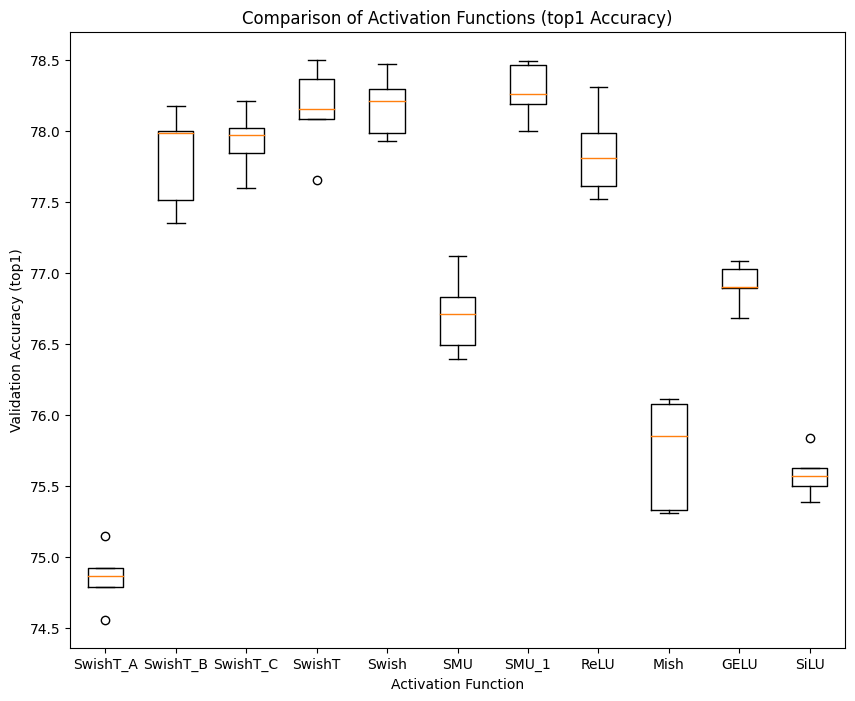

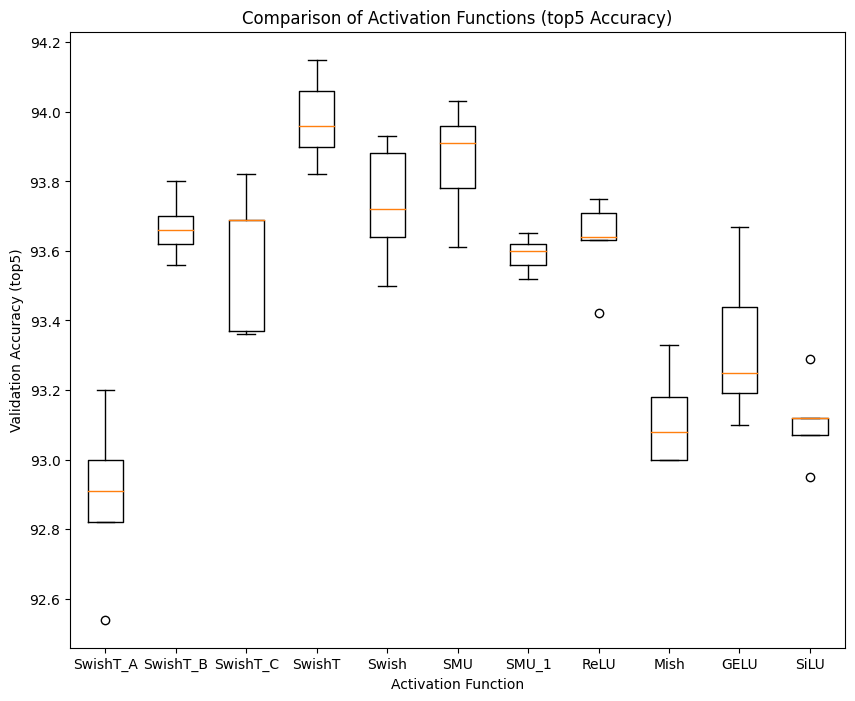

          Mean of top1  Std of top1  Mean of top5  Std of top5  Mean of beta  \
SwishT_A         74.86         0.19         92.89         0.22           NaN   
SwishT_B         77.80         0.31         93.67         0.08          6.07   
SwishT_C         77.93         0.20         93.59         0.19          6.16   
SwishT           78.15         0.29         93.98         0.12          5.94   
Swish            78.18         0.20         93.73         0.16          5.96   
SMU              76.71         0.26         93.86         0.15           NaN   
SMU_1            78.28         0.18         93.59         0.05           NaN   
ReLU             77.85         0.28         93.63         0.11           NaN   
Mish             75.74         0.35         93.12         0.12           NaN   
GELU             76.92         0.14         93.33         0.20           NaN   
SiLU             75.59         0.15         93.11         0.11           NaN   

          Std of beta                  

In [110]:
# base activations 
from experiments.activation.acts import *
from pprint import pprint

############# 1.1 M Resnet18 CIFAR10/100 result ##############
folder_path = f'./checkpoint/senet_cifar100' 
repeats = 5  # Total number of repeats
activation_fns = get_activations(return_type='list')
activation_fns = [act.__class__.__name__ for act in activation_fns]
activation_fns = ['SwishT_A','SwishT_B','SwishT_C']
activation_fns += ['SwishT','Swish','SMU','SMU_1','ReLU','Mish','GELU','SiLU']
# activation_fns.remove('Pserf')
# activation_fns.remove('ErfAct')

accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)

# Plot the boxplot for comparison
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top5')
df = summarize_accuracies(accuracies_dict)
pprint(df)
# pprint(df.sort_values(by='Mean of top1',ascending=False))
# pprint(df[['Mean of beta','Std of beta','Betas']])

############## CIFAR10
folder_path = f'./checkpoint/senet_cifar10' 
# activation_fns = ['SwishT','SliuT','ASN','Swish','Mish','GELU','SiLU']
accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)
# plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
df = summarize_accuracies(accuracies_dict)
pprint(df)
# df.sort_values(by='Mean of top1',ascending=False)

### DenseNet-121(k=12)

,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
SwishT,77.00,0.14,93.82,0.23,7.11,0.06,"[[7.22], [7.08], [7.04], [7.09], [7.1]]"
Swish,77.00,0.35,93.79,0.15,6.86,0.04,"[[6.91], [6.83], [6.91], [6.81], [6.84]]"
SwishT_B,76.96,0.12,93.76,0.15,7.19,0.02,"[[7.2], [7.16], [7.23], [7.18], [7.19]]"
SwishT_C,77.15,0.19,93.75,0.12,7.14,0.02,"[[7.15], [7.12], [7.13], [7.13], [7.17]]"
SMU,76.04,0.10,93.70,0.16,NaN,NaN,"[nan, nan, nan, nan, nan]"
ReLU,76.55,0.39,93.67,0.25,NaN,NaN,"[nan, nan, nan, nan, nan]"
SMU_1,76.89,0.22,93.59,0.21,NaN,NaN,"[nan, nan, nan, nan, nan]"
GELU,74.41,0.32,93.02,0.20,NaN,NaN,"[nan, nan, nan, nan, nan]"
SwishT_A,73.10,0.52,92.98,0.25,NaN,NaN,"[nan, nan, nan, nan, nan]"
SiLU,73.40,0.21,92.90,0.26,NaN,NaN,"[nan, nan, nan, nan, nan]"


          Mean of top1  Std of top1  Mean of top5  Std of top5  Mean of beta  \
SwishT_A         73.10         0.52         92.98         0.25           NaN   
SwishT_B         76.96         0.12         93.76         0.15          7.19   
SwishT_C         77.15         0.19         93.75         0.12          7.14   
SwishT           77.00         0.14         93.82         0.23          7.11   
Swish            77.00         0.35         93.79         0.15          6.86   
SMU              76.04         0.10         93.70         0.16           NaN   
SMU_1            76.89         0.22         93.59         0.21           NaN   
Mish             73.81         0.27         92.87         0.22           NaN   
GELU             74.41         0.32         93.02         0.20           NaN   
SiLU             73.40         0.21         92.90         0.26           NaN   
ReLU             76.55         0.39         93.67         0.25           NaN   

          Std of beta                  

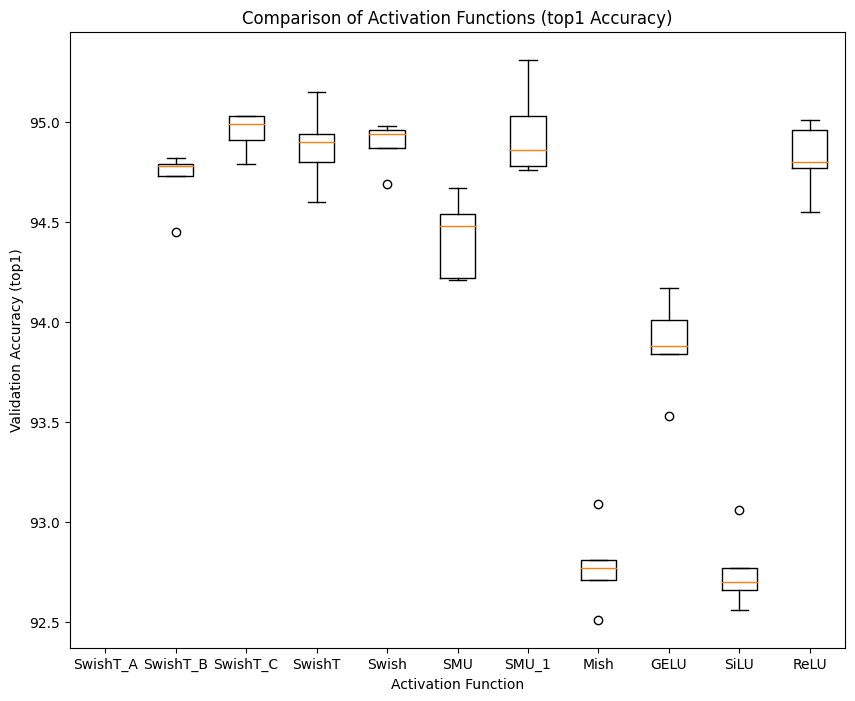

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
SwishT_A,NaN,NaN,NaN,NaN,NaN,NaN,[]
SwishT_B,94.71,0.14,0.0,0.0,5.95,0.02,"[[5.92], [5.93], [5.95], [5.98], [5.95]]"
SwishT_C,94.95,0.09,0.0,0.0,6.14,0.05,"[[6.13], [6.2], [6.1], [6.07], [6.19]]"
SwishT,94.88,0.18,0.0,0.0,6.12,0.04,"[[6.11], [6.08], [6.09], [6.12], [6.18]]"
Swish,94.89,0.11,0.0,0.0,5.98,0.01,"[[5.98], [5.96], [5.97], [5.99], [5.99]]"
SMU,94.42,0.18,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
SMU_1,94.95,0.20,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
Mish,92.78,0.19,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
GELU,93.89,0.21,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
SiLU,92.75,0.17,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"


          Mean of top1  Std of top1  Mean of top5  Std of top5  Mean of beta  \
SwishT_A           NaN          NaN           NaN          NaN           NaN   
SwishT_B         94.71         0.14           0.0          0.0          5.95   
SwishT_C         94.95         0.09           0.0          0.0          6.14   
SwishT           94.88         0.18           0.0          0.0          6.12   
Swish            94.89         0.11           0.0          0.0          5.98   
SMU              94.42         0.18           0.0          0.0           NaN   
SMU_1            94.95         0.20           0.0          0.0           NaN   
Mish             92.78         0.19           0.0          0.0           NaN   
GELU             93.89         0.21           0.0          0.0           NaN   
SiLU             92.75         0.17           0.0          0.0           NaN   
ReLU             94.82         0.16           0.0          0.0           NaN   

          Std of beta                  

,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
SwishT_C,94.95,0.09,0.0,0.0,6.14,0.05,"[[6.13], [6.2], [6.1], [6.07], [6.19]]"
SMU_1,94.95,0.20,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
Swish,94.89,0.11,0.0,0.0,5.98,0.01,"[[5.98], [5.96], [5.97], [5.99], [5.99]]"
SwishT,94.88,0.18,0.0,0.0,6.12,0.04,"[[6.11], [6.08], [6.09], [6.12], [6.18]]"
ReLU,94.82,0.16,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
SwishT_B,94.71,0.14,0.0,0.0,5.95,0.02,"[[5.92], [5.93], [5.95], [5.98], [5.95]]"
SMU,94.42,0.18,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
GELU,93.89,0.21,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
Mish,92.78,0.19,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
SiLU,92.75,0.17,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"


In [88]:
# base activations 
from experiments.activation.acts import *
from pprint import pprint

############# 1.1 M Resnet18 CIFAR10/100 result ##############
folder_path = f'./checkpoint/densenet_cifar100' 
repeats = 5  # Total number of repeats
activation_fns = get_activations(return_type='list')
activation_fns = [act.__class__.__name__ for act in activation_fns]
activation_fns = ['SwishT_A','SwishT_B','SwishT_C']
activation_fns += ['SwishT','Swish','SMU','SMU_1','Mish','GELU','SiLU','ReLU']
# activation_fns.remove('Pserf')
# activation_fns.remove('ErfAct')

accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)

# Plot the boxplot for comparison
# plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
# plot_accuracies_boxplot(accuracies_dict,accuracy_type='top5')
df = summarize_accuracies(accuracies_dict)
display(df.sort_values(by='Mean of top5',ascending=False))
# pprint(df[['Mean of beta','Std of beta','Betas']])
pprint(df)


############## CIFAR10
# activation_fns = ['SwishT','SliuT','ASN','Swish','Mish','GELU','SiLU']
folder_path = f'./checkpoint/densenet_cifar10' 
accuracies_dict = load_model_checkpoints(folder_path, activation_fns, 5)
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
df = summarize_accuracies(accuracies_dict)
display(df)
pprint(df)
df.sort_values(by='Mean of top1',ascending=False)

### mobilenetv2

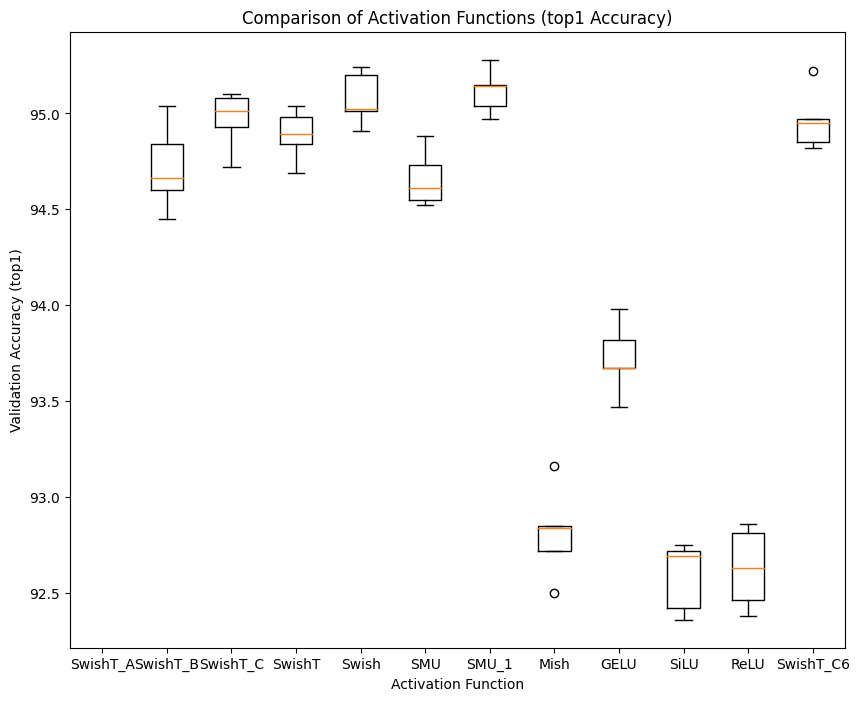

           Mean of top1  Std of top1  Mean of top5  Std of top5  Mean of beta  \
SwishT_A            NaN          NaN           NaN          NaN           NaN   
SwishT_B          94.72         0.20           0.0          0.0          7.10   
SwishT_C          94.97         0.14           0.0          0.0          6.99   
SwishT            94.89         0.12           0.0          0.0          7.05   
Swish             95.08         0.12           0.0          0.0          6.80   
SMU               94.66         0.13           0.0          0.0           NaN   
SMU_1             95.12         0.11           0.0          0.0           NaN   
Mish              92.81         0.21           0.0          0.0           NaN   
GELU              93.72         0.17           0.0          0.0           NaN   
SiLU              92.59         0.16           0.0          0.0           NaN   
ReLU              92.63         0.19           0.0          0.0           NaN   
SwishT_C6         94.96     

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
SMU_1,95.12,0.11,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
Swish,95.08,0.12,0.0,0.0,6.80,0.02,"[[6.83], [6.82], [6.78], [6.8], [6.79]]"
SwishT_C,94.97,0.14,0.0,0.0,6.99,0.02,"[[6.99], [6.98], [6.97], [7.01], [6.98]]"
SwishT_C6,94.96,0.14,0.0,0.0,6.00,0.00,"[[6.0], [6.0], [6.0], [6.0], [6.0]]"
SwishT,94.89,0.12,0.0,0.0,7.05,0.03,"[[7.08], [7.04], [7.1], [7.03], [7.02]]"
SwishT_B,94.72,0.20,0.0,0.0,7.10,0.02,"[[7.11], [7.06], [7.12], [7.12], [7.07]]"
SMU,94.66,0.13,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
GELU,93.72,0.17,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
Mish,92.81,0.21,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
ReLU,92.63,0.19,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"


In [111]:
# base activations 
from experiments.activation.acts import *
from pprint import pprint

############# 1.1 M Resnet18 CIFAR10/100 result ##############
folder_path = f'./checkpoint/mov2_cifar10' 
repeats = 5  # Total number of repeats
activation_fns = get_activations(return_type='list')
activation_fns = [act.__class__.__name__ for act in activation_fns]
activation_fns = ['SwishT_A','SwishT_B','SwishT_C']
activation_fns += ['SwishT','Swish','SMU','SMU_1','Mish','GELU','SiLU','ReLU','SwishT_C6']
# activation_fns.remove('Pserf')
# activation_fns.remove('ErfAct')

############## CIFAR10
# activation_fns = ['SwishT','SliuT','ASN','Swish','Mish','GELU','SiLU']
accuracies_dict = load_model_checkpoints(folder_path, activation_fns, 5)
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
df = summarize_accuracies(accuracies_dict)
pprint(df)
df.sort_values(by='Mean of top1',ascending=False)

### EfficientNetB0

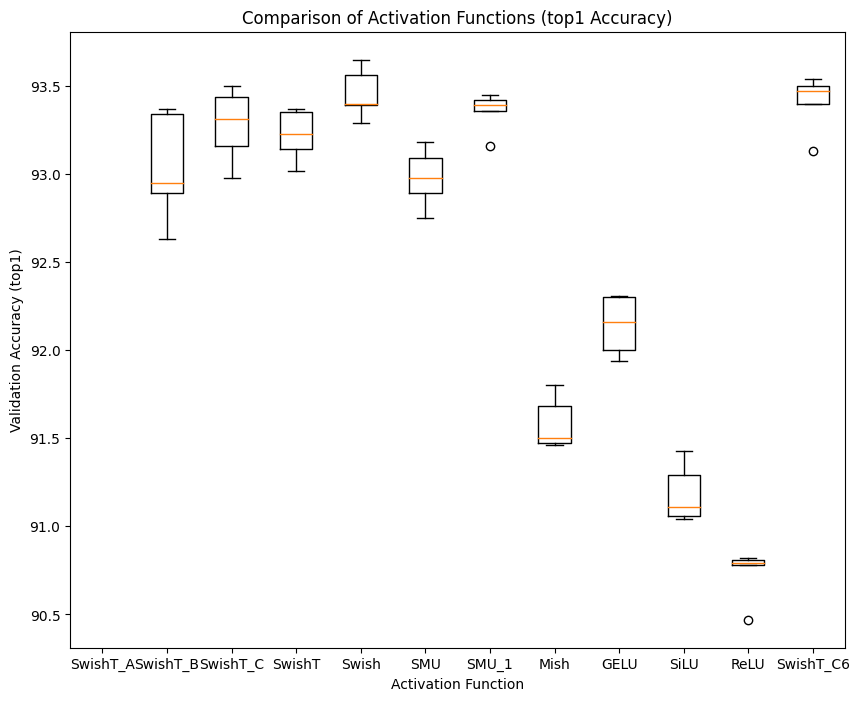

           Mean of top1  Std of top1  Mean of top5  Std of top5  Mean of beta  \
SwishT_A            NaN          NaN           NaN          NaN           NaN   
SwishT_B          93.04         0.28           0.0          0.0         -4.91   
SwishT_C          93.28         0.19           0.0          0.0          6.31   
SwishT            93.22         0.13           0.0          0.0          6.39   
Swish             93.46         0.13           0.0          0.0          6.12   
SMU               92.98         0.15           0.0          0.0           NaN   
SMU_1             93.36         0.10           0.0          0.0           NaN   
Mish              91.58         0.14           0.0          0.0           NaN   
GELU              92.14         0.15           0.0          0.0           NaN   
SiLU              91.19         0.15           0.0          0.0           NaN   
ReLU              90.73         0.13           0.0          0.0           NaN   
SwishT_C6         93.41     

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
Swish,93.46,0.13,0.0,0.0,6.12,0.06,"[[6.24], [6.06], [6.1], [6.13], [6.09]]"
SwishT_C6,93.41,0.15,0.0,0.0,6.00,0.00,"[[6.0], [6.0], [6.0], [6.0], [6.0]]"
SMU_1,93.36,0.10,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
SwishT_C,93.28,0.19,0.0,0.0,6.31,0.01,"[[6.34], [6.3], [6.32], [6.3], [6.3]]"
SwishT,93.22,0.13,0.0,0.0,6.39,0.05,"[[6.47], [6.38], [6.31], [6.41], [6.4]]"
SwishT_B,93.04,0.28,0.0,0.0,-4.91,0.04,"[[-4.96], [-4.94], [-4.89], [-4.87], [-4.87]]"
SMU,92.98,0.15,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
GELU,92.14,0.15,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
Mish,91.58,0.14,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"
SiLU,91.19,0.15,0.0,0.0,NaN,NaN,"[nan, nan, nan, nan, nan]"


In [113]:
# base activations 
from experiments.activation.acts import *
from pprint import pprint

############# 1.1 M Resnet18 CIFAR10/100 result ##############
folder_path = f'./checkpoint/effi_cifar10' 
repeats = 5  # Total number of repeats
activation_fns = get_activations(return_type='list')
activation_fns = [act.__class__.__name__ for act in activation_fns]
activation_fns = ['SwishT_A','SwishT_B','SwishT_C']
activation_fns += ['SwishT','Swish','SMU','SMU_1','Mish','GELU','SiLU','ReLU','SwishT_C6']
# activation_fns.remove('Pserf')
# activation_fns.remove('ErfAct')

############## CIFAR10
# activation_fns = ['SwishT','SliuT','ASN','Swish','Mish','GELU','SiLU']
accuracies_dict = load_model_checkpoints(folder_path, activation_fns, 5)
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
df = summarize_accuracies(accuracies_dict)
pprint(df)
df.sort_values(by='Mean of top1',ascending=False)

In [132]:
torch.load('./checkpoint/dev_GLUs_conv_cifar100/3_ckpt_resnet18_CIFAR100_SwiGLU_78.42.pth').keys() 

dict_keys(['net', 'acc', 'epoch', 'act', 'top1', 'top5'])

In [102]:
def print_params(act=SMU(),path='',arch='ResNet18',n_classes=100,net_size=2.):
    '''
        acrh : ShuffleNetV2, Resnet18, ...
    '''
    import models
    if 'shufflenet' in str.lower(arch):
        load_model = f'models.{arch}(n_classes={n_classes},act=act,net_size={net_size})'
    else :
        load_model = f'models.{arch}(n_classes={n_classes},act=act)'

    model = eval(load_model)
    state_dict = torch.load(path,map_location='cpu')
    print(state_dict)
    model.load_state_dict(state_dict['net'])

    for name, module in model.named_modules():
        if 'act' in name:
            print(name)
            for p in module.parameters():
                print(p.detach().numpy())

def print_params_SMU(act=SMU(),path='',arch='ResNet18',n_classes=100,net_size=2.):
    '''
        acrh : ShuffleNetV2, Resnet18, ...
    '''
    import models
    if 'shufflenet' in str.lower(arch):
        load_model = f'models.{arch}(n_classes={n_classes},act=act,net_size={net_size})'
    else :
        load_model = f'models.{arch}(n_classes={n_classes},act=act)'

    model = eval(load_model)
    state_dict = torch.load(path,map_location='cpu')
    print(state_dict['net']['module.act.mu'])

print_params_SMU(arch='ShuffleNetV2',n_classes=10,act=SMU(),path=r'checkpoint/shfv2_1_cifar10/1_ckpt_resnet18_CIFAR10_SMU_94.22.pth')

tensor([5.9030])


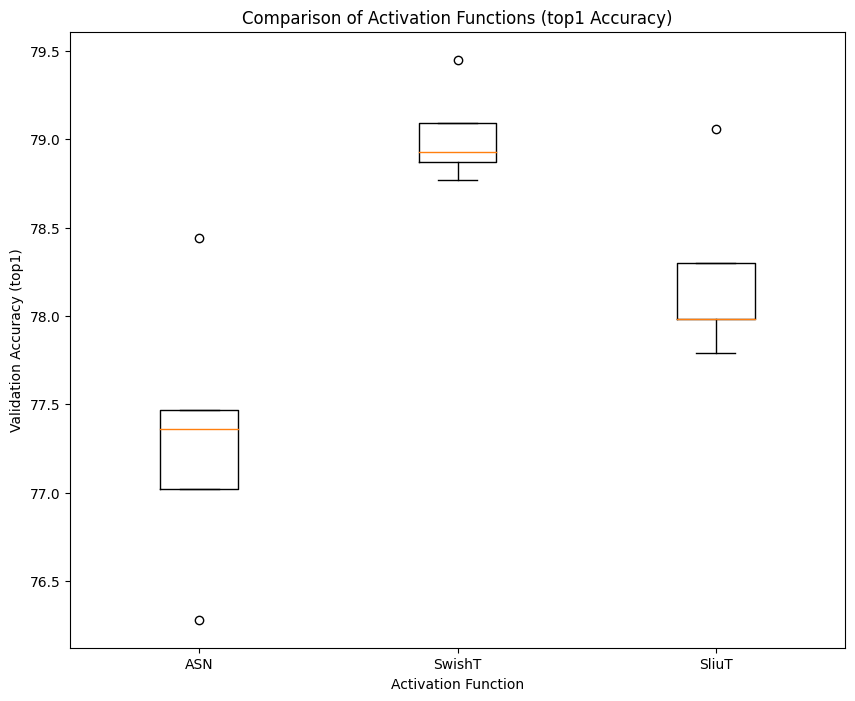

,Mean of top1,Std of top1,Mean of top5,Std of top5,Mean of beta,Std of beta,Betas
SwishT,79.02,0.24,94.25,0.11,6.45,0.02,"[[6.46], [6.45], [6.42], [6.42], [6.47]]"
SliuT,78.22,0.45,94.17,0.19,-7.17,0.04,"[[-7.17], [-7.16], [-7.25], [-7.14], [-7.14]]"
ASN,77.31,0.70,93.35,0.24,5.67,0.03,"[[5.7], [5.69], [5.65], [5.65], [5.63]]"


In [95]:
# base activations 
from experiments.activation.acts import *
from pprint import pprint

############# 1.1 M Resnet18 CIFAR10/100 result ##############
folder_path = f'./checkpoint/dev_cifar100' 
repeats = 5  # Total number of repeats

activation_fns = ['ASN','SwishT','SliuT']
# activation_fns.remove('Pserf')
# activation_fns.remove('ErfAct')

############## CIFAR10
# activation_fns = ['SwishT','SliuT','ASN','Swish','Mish','GELU','SiLU']
accuracies_dict = load_model_checkpoints(folder_path, activation_fns, 5)
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
df = summarize_accuracies(accuracies_dict)
# pprint(df)
df.sort_values(by='Mean of top1',ascending=False)

### Ablation Study
- batch size 512,256,64,32

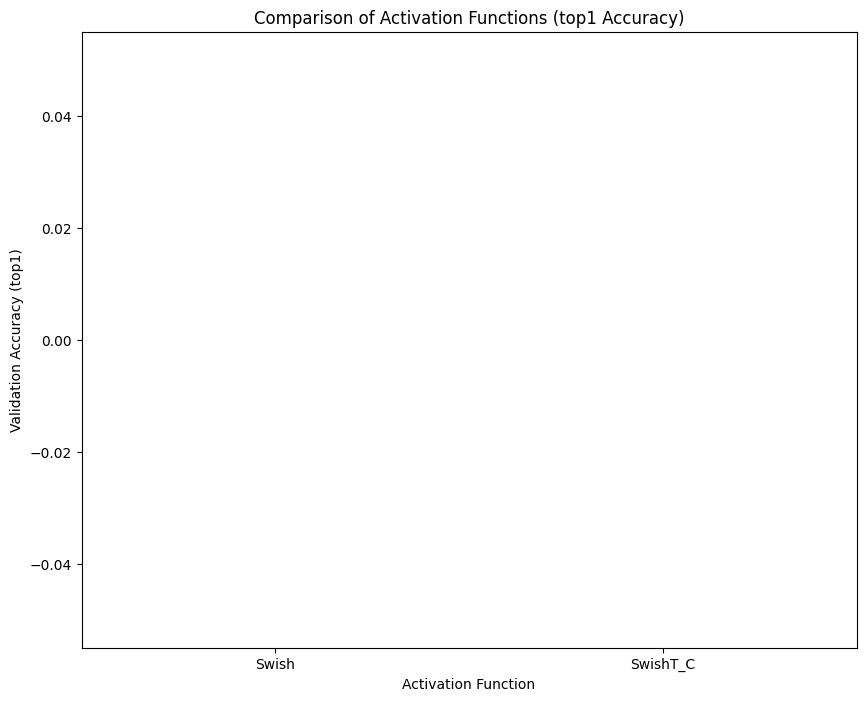

          Mean of top1  Std of top1  Mean of top5  Std of top5  Mean of beta  \
Swish              NaN          NaN           NaN          NaN           NaN   
SwishT_C           NaN          NaN           NaN          NaN           NaN   

          Std of beta Betas  
Swish             NaN    []  
SwishT_C          NaN    []  


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
# base activations 
from experiments.activation.acts import *
from pprint import pprint

folder_path = f'./checkpoint/ab_senet_cifar10_bs32' 
repeats = 5  # Total number of repeats
activation_fns = ['Swish','SwishT_C']

accuracies_dict = load_model_checkpoints(folder_path, activation_fns, repeats)

# Plot the boxplot for comparison
plot_accuracies_boxplot(accuracies_dict,accuracy_type='top1')
df = summarize_accuracies(accuracies_dict)
pprint(df)
